In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, signal, spatial

import os
import pandas as pd

from skimage import morphology, graph

import gudhi as gd

In [2]:
def read_binary_img(filename, threshold=100):
    bimg = cv2.imread(filename)[:,:,0]
    bimg[bimg < threshold] = 0
    bimg[bimg > 0] = 1
    bimg = bimg.astype(bool)

    return bimg

def clean_zeros_2d(img, pad=2):
    foo = np.nonzero(np.any(img, axis=0))[0]
    vceros = np.array([ max([0,foo[0] - pad]), min([img.shape[1], foo[-1]+pad]) ])
    
    foo = np.nonzero(np.any(img, axis=1))[0]
    hceros = np.array([ max([0,foo[0] - pad]), min([img.shape[0], foo[-1]+pad]) ])

    img = img[hceros[0]:hceros[1], vceros[0]:vceros[1]]
    
    return img, vceros, hceros

def merge_strands(gimg, maxdist=100, iterations=3):
    main = gimg.copy()
    rest = gimg.copy()
    lines = np.zeros_like(main)
                          
    label, nums = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    
    print(np.round(100*hist[hargsort[:10]]/np.sum(hist),1))

    # Define the principal connected component and the rest of separate strands
    
    main[label != bins[hargsort[0]]] = False
    rest[label == bins[hargsort[0]]] = False

    # Only consider the pixels at each end of the strands

    skel = morphology.skeletonize(rest)
    g,nodes = graph.pixel_graph(skel, connectivity=2)
    
    argleaf = np.nonzero(np.sum(g.A > 0, axis=0) == 1)[0]
    leafx = nodes[argleaf]%skel.shape[1]
    leafy = nodes[argleaf]//skel.shape[1]
    leafz = label[leafy, leafx]

    # Find the pixels of the main component that are closest to these ends
    
    edt = ndimage.distance_transform_edt(~main, return_distances=False, return_indices=True)
    eidx = edt[:, leafy, leafx]
    sdist = np.sqrt((leafy - eidx[0])**2 + (leafx - eidx[1])**2)
    eidx = eidx.T
    # For each strand, consider all the ends and draw the shortest possible connecting line
    
    for i in np.unique(leafz):
        dmask = leafz == i
        cidx = np.argmin(sdist[dmask])
        if sdist[dmask][cidx] < maxdist:
            p0 = np.array([leafx[dmask][cidx], leafy[dmask][cidx]])
            p1 = eidx[dmask][cidx][::-1]
            
            lams = np.linspace(0,1, 2*int(sdist[dmask][cidx]))
            line = (p0.reshape(-1,1) + lams*(p1 - p0).reshape(-1,1)).astype(int)
            lines[line[1], line[0]] = True

    lines = ndimage.binary_dilation(lines, ndimage.generate_binary_structure(2,2), iterations)
    gimg = gimg | lines
    
    foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',bar,'connected components after processing')

    return gimg, bar

In [12]:
genotypes = ['CAL','MLB','222','299','517','521']
imtype = ['Diseased', 'Healthy', 'Binary']
runnum = 1
src = '../run{:02d}/'.format(runnum)
gdst = src + 'diagnostic/'
pdst = src + 'processed/'
if not os.path.isdir(gdst):
    os.mkdir(gdst)

if not os.path.isdir(pdst):
    os.mkdir(pdst)

gidx = 2
bfiles = sorted(glob(src + '{}*/*{}*.jpg'.format(imtype[2], genotypes[gidx])))
print('Total number of files:\t{}\n'.format(len(bfiles)))
for i in range(len(bfiles)):
    print(i, bfiles[i], sep='\t')

Total number of files:	8

0	../run01/Binary_Images/222F_side1_022817002.jpg_Binary_roots.jpg
1	../run01/Binary_Images/222F_side1_030117010.jpg_Binary_roots.jpg
2	../run01/Binary_Images/222F_side2_022817003.jpg_Binary_roots.jpg
3	../run01/Binary_Images/222F_side2_030117011.jpg_Binary_roots.jpg
4	../run01/Binary_Images/222M_side1_022817026.jpg_Binary_roots.jpg
5	../run01/Binary_Images/222M_side1_030117006.jpg_Binary_roots.jpg
6	../run01/Binary_Images/222M_side2_022817027.jpg_Binary_roots.jpg
7	../run01/Binary_Images/222M_side2_030117007.jpg_Binary_roots.jpg


In [17]:
idx = 5
print(bfiles[idx])
bimg = read_binary_img(bfiles[idx])
bname = os.path.splitext(os.path.split(bfiles[idx])[1])[0].split('_ivc')[0].replace(' ','')
img = bimg.copy()

img, vceros, hceros = clean_zeros_2d(img)
print(vceros, hceros, sep='\n')

../run01/Binary_Images/222M_side1_030117006.jpg_Binary_roots.jpg
[1793 3646]
[   0 2708]


# Connect missing bits to the main component

In [18]:
gimg = img.copy()
maxdist = 50
nums1, nums2 = 2,3

for i in range(6):
    dist = maxdist * (i+1)
    while (nums1 > 1) and (nums1 != nums2):
        nums2 = nums1
        gimg, nums1 = merge_strands(gimg, dist)
    nums2 += 1

if nums1 > 1:
    label, nums = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    gimg[label != bins[hargsort[0]]] = False

    foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',bar,'connected components after ultimate processing')

[97.6  1.3  0.5  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
Found 2 connected components after processing
[99.9  0.1]
Found 1 connected components after processing


../run01/diagnostic/222M_side1_030117006.jpg_Binary_roots_fixed_strands


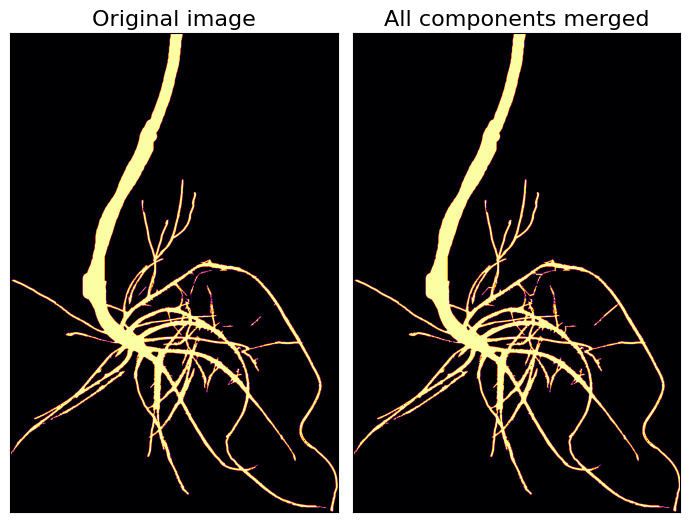

In [19]:
fs = 16; s = 30
fig, ax = plt.subplots(1,2, figsize=(7,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([img, gimg]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    
i = 0
#ax[i].set_ylabel(bname, fontsize=fs)
ax[i].set_title('Original image', fontsize=fs); i+=1
ax[i].set_title('All components merged', fontsize=fs); i+=1

fig.tight_layout();

filename = gdst + bname + '_fixed_strands'
print(filename)
plt.savefig(filename+'.png', format='png', bbox_inches='tight', dpi=200)

In [20]:
filename = pdst + bname + '_-_completed_binary_{}_{}_{}_{}.npy'.format(*vceros, *hceros)
print(filename)
np.save(filename, gimg, allow_pickle=True)

../run01/processed/222M_side1_030117006.jpg_Binary_roots_-_completed_binary_1793_3646_0_2708.npy


In [ ]:
label, nums = ndimage.label(img, structure=ndimage.generate_binary_structure(2,1))
print('Found',nums,'connected components')
hist, bins = np.histogram(label, bins=range(1,nums+2))
print(np.round(100*np.sort(hist)[::-1]/np.sum(hist),1))
print(np.sort(hist)[::-1])
hargsort = np.argsort(hist)[::-1]

main = img.copy()
main[label != bins[hargsort[0]]] = False
print('Largest label:\t', bins[hargsort[0]])
edt = ndimage.distance_transform_edt(~main, return_distances=False, return_indices=True)

pad = 5
gimg = img.copy()

rest = img.copy()
rest[label == bins[hargsort[0]]] = False
skel = morphology.skeletonize(rest)
g,nodes = graph.pixel_graph(skel, connectivity=2)

argleaf = np.nonzero(np.sum(g.A > 0, axis=0) == 1)[0]
leafx = nodes[argleaf]%skel.shape[1]
leafy = nodes[argleaf]//skel.shape[1]
leafz = label[leafy, leafx]

eidx = np.zeros((len(leafx), 2), dtype=int)
for i in range(len(eidx)):
    eidx[i] = edt[:, leafy[i], leafx[i]]

sdist = np.zeros(len(leafx))
for i in range(len(sdist)):
    sdist[i] = (leafx[i]-eidx[i,1])**2 + (leafy[i]-eidx[i,0])**2
sdist = np.sqrt(sdist)

for i in range(nums):
    dmask = leafz == i+1
    if np.sum(dmask) > 0:
        cidx = np.argmin(sdist[dmask])
        if sdist[dmask][cidx] < 350:
            p0 = np.array([leafx[dmask][cidx], leafy[dmask][cidx]])
            p1 = eidx[dmask][cidx][::-1]
            
            lams = np.linspace(0,1, 2*int(sdist[dmask][cidx]))
            
            for j in range(len(lams)):
                line = p0 + lams[j]*(p1 - p0)
                line = line.astype(int)
                gimg[ line[1]-pad:line[1]+pad, line[0]-pad:line[0]+pad] = True
        
        else:
            gimg[ label == i+1] = False
            print(i, sdist[dmask], sep='\t')

foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
print('Found',bar,'connected components after processing')

In [ ]:
fs = 16; s = 30
fig, ax = plt.subplots(1,4, figsize=(12,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([img, main, rest, gimg]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    
ax[1].scatter(eidx[:,1], eidx[:,0], c='red', marker='^', edgecolor='w', linewidth=0.5, s=s, label='Closest pixel')
ax[2].scatter(leafx, leafy, c='blue', marker='v', edgecolor='yellow', linewidth=0.5, s=s, label='End pixel')
for i in [1,2]:
    ax[i].legend(loc='upper right', fontsize=fs-4)

i = 0
ax[i].set_title('Original image', fontsize=fs); i+=1
ax[i].set_title('Main connected component', fontsize=fs); i+=1
ax[i].set_title('Rest of components', fontsize=fs); i+=1
ax[i].set_title('All components merged', fontsize=fs); i+=1

fig.tight_layout();